In [8]:
!pip install kagglehub

In [9]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import kagglehub

In [10]:
path = kagglehub.dataset_download(
    "hendrichscullen/vehide-dataset-automatic-vehicle-damage-detection"
)

print("Dataset path:", path)

Using Colab cache for faster access to the 'vehide-dataset-automatic-vehicle-damage-detection' dataset.
Dataset path: /kaggle/input/vehide-dataset-automatic-vehicle-damage-detection


In [11]:
IMG_SIZE = 128
MAX_IMAGES = 600

images = []

for root, dirs, files in os.walk(path):
    image_files = [
        f for f in files
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    for img_file in image_files:
        if len(images) >= MAX_IMAGES:
            break

        img_path = os.path.join(root, img_file)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)

    if len(images) >= MAX_IMAGES:
        break

images = np.array(images, dtype=np.float32)

print("Loaded images:", images.shape)

Loaded images: (600, 128, 128, 3)


In [20]:
inputs = tf.keras.Input(shape=(128, 128, 3))

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

embedding = tf.keras.layers.Dense(128, activation='relu', name="embedding")(x)

# Simple proxy classifier (2 classes, even if noisy)
outputs = tf.keras.layers.Dense(2, activation='softmax')(embedding)

model = tf.keras.Model(inputs, outputs)


In [21]:
labels = np.random.randint(0, 2, size=len(images))  # proxy labels

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy'
)

model.fit(
    images,
    labels,
    epochs=5,
    batch_size=32,
    shuffle=True
)


Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 653ms/step - loss: 0.6979
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 681ms/step - loss: 0.6924
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step - loss: 0.6929
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 646ms/step - loss: 0.6917
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - loss: 0.6925


In [22]:
embedding_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("embedding").output
)

embeddings = embedding_model.predict(images)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


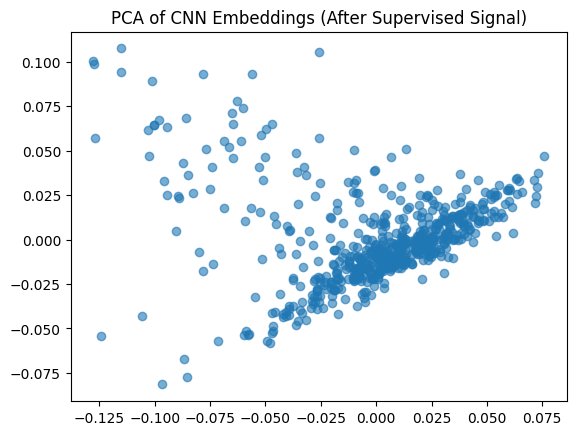

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.6)
plt.title("PCA of CNN Embeddings (After Supervised Signal)")
plt.show()
